In [3]:
#@title
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py


In [74]:
rho = 1.2; g = 9.81                            
mass = 0.0025; diameter = 0.019 

# estimates of v_terms for penny range from 15-29 m/s (roughly 30-65 mph)
v_term = 22.0
v_init = 0.0
height = 381 

params = dict(mass = mass, diameter=diameter, rho = rho,          
    g = g, v_init = v_init,  v_term = v_term,        
    height = height, t_end = 30)

In [69]:
def make_system(params):
    mass, diameter, rho, g, v_init, v_term, height, t_end = params.values()
    
    init = pd.Series(dict(y=height, v=v_init))

    area = 3.1415 * (diameter/2)**2
    C_d = (2 * mass * g / (rho * area * v_term**2))

    return dict(init=init,
                  area=area,
                  C_d=C_d,
                  mass=mass,
                  rho=rho,
                  g=g,
                  v_term = v_term,
                  t_end=t_end)

In [75]:
system = make_system(params)
system['C_d']

0.2978709355151035

In [83]:
# Define a wind function that oscilates sinusoidally around an average value
from numpy import sin, pi,abs, min, max

def wind(t, ave, variation, period):
    frequency = 1/period
    wind = ave + variation * sin(t*2.0*pi*frequency)
    return wind

# Define a function that randomly adjusts the orientation of the penny,
# causing the coefficient of drag to change.
def orientation(C_d):
    max_cd = 0.64
    min_cd = 0.17
    if flip(0.5):
        C_d = min([C_d * 1.05,max_cd])
    else:
        C_d = max([C_d * 0.95, min_cd])
    
    return C_d

In [87]:
def slope_func(t, state, system):

    y, v = state
    rho, C_d, area = system['rho'], system['C_d'], system['area']
    mass, g = system['mass'], system['g']
    
    # positive updraft is wind in upwards direction
    updraft = wind(t,5.0,5.0,5.0)   
    air_v = v - updraft

    # Adjust C_d based on random change in orientation
    system['C_d'] = orientation(C_d)
    f_drag = rho * air_v**2 * system['C_d'] * area / 2
    
    if air_v < 0:
        a_drag = f_drag / mass 
    else:
        a_drag = -f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag 
    
    return dydt, dvdt

def event_func(t, state, system):
    y, v = state
    return y

final velocity -17.52 time 29.0


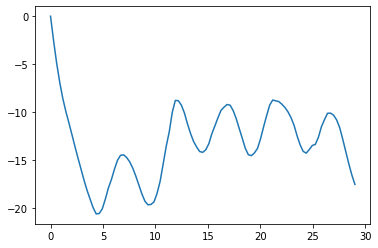

In [105]:
system = make_system(params)
results, details = run_solve_ivp(system, slope_func, events=event_func)
results.v.plot();
print("final velocity", round(results.v.iloc[-1],2), "time", round(results.index[-1],2))

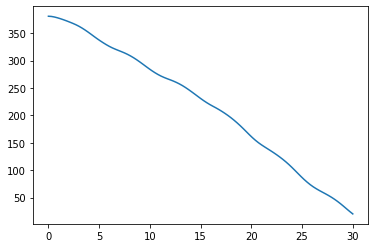

In [96]:
results.y.plot();